In [0]:
!pip install fastai2 -q
!pip install git+https://github.com/rbracco/fastai2_audio.git -q

     |████████████████████████████████| 194kB 3.5MB/s 
     |████████████████████████████████| 3.2MB 3.4MB/s 


In [0]:
from fastai2.vision.all import *
from fastai2_audio.core import*
from fastai2_audio.augment import *

In [0]:
path=Path('/content/drive/My Drive/train_catdog/train')
path.ls()


(#221) [Path('/content/drive/My Drive/train_catdog/train/cat_147.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_103.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_140.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_102 (1).wav'),Path('/content/drive/My Drive/train_catdog/train/cat_131.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_122.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_136.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_142.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_109.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_119.wav')...]

In [0]:
fnames=get_audio_files(path)

In [0]:
fnames

(#221) [Path('/content/drive/My Drive/train_catdog/train/cat_147.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_103.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_140.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_102 (1).wav'),Path('/content/drive/My Drive/train_catdog/train/cat_131.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_122.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_136.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_142.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_109.wav'),Path('/content/drive/My Drive/train_catdog/train/cat_119.wav')...]

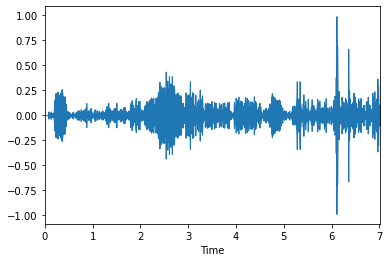

In [0]:
at=AudioTensor.create(fnames[100])
at.show()

In [0]:
crop7s=CropSignal(7000)

Using spectrograms

In [0]:
cfg=AudioConfig.Voice()

In [0]:
aud2spec=AudioToSpec.from_cfg(cfg)

In [0]:
aud2spec.settings

{'f_max': 8000.0,
 'f_min': 50.0,
 'hop_length': 128,
 'mel': 'True',
 'n_fft': 1024,
 'n_mels': 128,
 'pad': 0,
 'sample_rate': 16000,
 'stype': 'power',
 'to_db': 'False',
 'top_db': None,
 'win_length': 1024,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None}

In [0]:
spec_tfms=SpectrogramTransformer()

In [0]:
aud2spec = spec_tfms(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

In [0]:
item_tfms=[RemoveSilence(),crop7s, aud2spec, MaskTime(size=4),MaskFreq(size=10)]

In [0]:
get_y= lambda y: y.name[:3]

In [0]:
aud_dblk=DataBlock(blocks=[AudioBlock, CategoryBlock],
                   get_items=get_audio_files,
                   splitter=RandomSplitter(),
                   item_tfms=item_tfms,
                   get_y=get_y
                   )

In [0]:
dls=aud_dblk.dataloaders(path,verbose=True, bs=64)

Setting up after_item: Pipeline: RemoveSilence.<locals>._inner -> CropSignal.<locals>._inner -> AudioToSpec -> MaskTime.<locals>._inner -> MaskFreq.<locals>._inner -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor


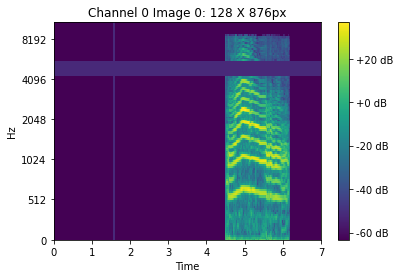

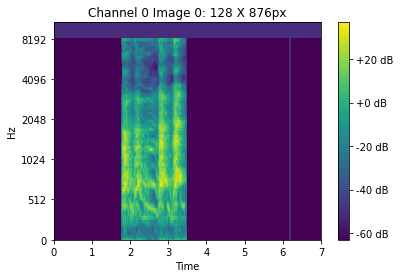

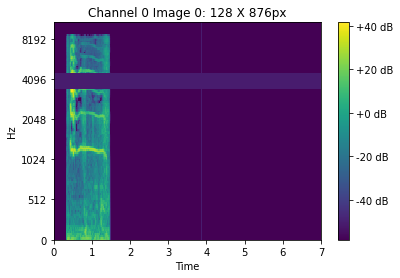

cat
dog
cat


In [0]:
dls.show_batch(max_n=3)

In [0]:
#from Zach Mueller's notebook
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [0]:
def audio_learner(dls, arch, loss_func, metrics):
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: 
    print("n_channels=1.....using alter_learner")
    alter_learner(learn)
  return learn

In [0]:
arch=xresnet50(act_cls=Mish)

In [0]:
learn=audio_learner(dls,arch,loss_func=CrossEntropyLossFlat(),metrics=accuracy).to_fp16()

n_channels=1.....using alter_learner


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.002511886414140463)

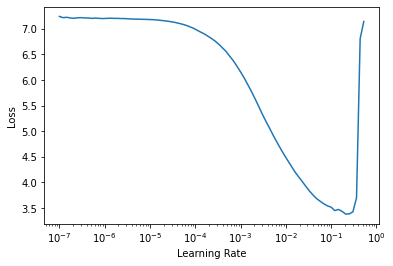

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,6.823079,35.873226,0.681818,01:00
1,4.810286,48.522861,0.659091,00:22
2,3.651722,51.259945,0.681818,00:22
3,2.912900,7.092707,0.681818,00:22
4,2.395257,1.082268,0.750000,00:22


In [0]:
learn.save('stage1');

In [0]:
learn.fit_one_cycle(5,1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.527561,0.616957,0.818182,00:22
1,0.504802,0.789211,0.727273,00:22
2,0.454317,0.741610,0.727273,00:21
3,0.433677,0.473254,0.795455,00:21
4,0.416256,0.501614,0.818182,00:21


In [0]:
learn.save('stage2')

In [0]:
tat=AudioTensor.create('/content/cat_3.wav')

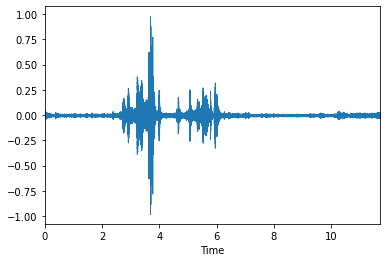

In [0]:
tat.show()

In [0]:
pred,_,_=learn.predict(tat)

In [0]:
pred

'cat'

Using Mel Frequency Cepstral Co-efficient(MFCC)

In [0]:
aud2mfcc=AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,
                                             'n_mels':128})

In [0]:
item_tfms=[crop7s,aud2mfcc,Delta()]

In [0]:
aud_dblk.item_tfms=item_tfms

In [0]:
dls=aud_dblk.dataloaders(path,bs=128)

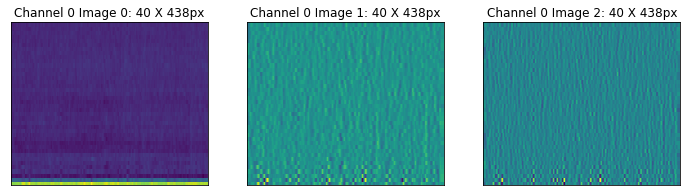

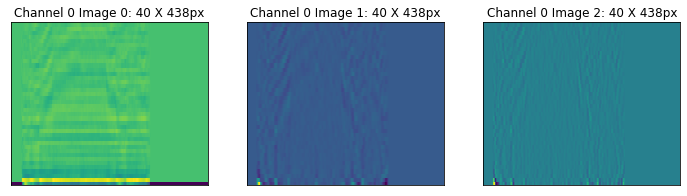

dog
dog


In [0]:
dls.show_batch(max_n=2)

In [0]:
arch=xresnet18()

In [0]:
learn=Learner(dls,arch,loss_func=CrossEntropyLossFlat(),metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

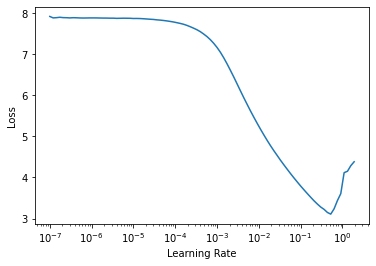

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,7.890554,10.062156,0.000000,01:29
1,7.680068,6.263288,0.318182,00:26
2,6.498151,15.959799,0.318182,00:26
3,5.091224,31.076881,0.318182,00:26
4,4.130442,29.152699,0.318182,00:26


In [0]:
learn.save('stage1')

In [0]:
learn.fit_one_cycle(10,1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.387658,20.913929,0.318182,00:25
1,0.455568,16.185053,0.318182,00:25
2,0.427270,12.746134,0.318182,00:25
3,0.459044,10.048862,0.318182,00:25
4,0.438637,7.567235,0.318182,00:25
5,0.435242,5.561009,0.340909,00:25
6,0.416755,3.984034,0.386364,00:25
7,0.402375,3.049650,0.409091,00:25
8,0.391092,2.267894,0.545455,00:25
9,0.381652,1.916775,0.568182,00:26


In [0]:
learn.fit_one_cycle(5,0.00075)

In [0]:
learn.fit_one_cycle(5,0.0075)

KeyboardInterrupt: ignored

In [0]:
learn.save('stage4')

In [0]:
learn.load('stage4')

In [0]:
learn.fit_one_cycle(1,0.0075)

epoch,train_loss,valid_loss,accuracy,time
0,0.189487,0.499571,0.840909,00:26


In [0]:
tat=AudioTensor.create(fnames[46])

In [0]:
pred,_,_=learn.predict(tat)

In [0]:
pred

'cat'